# Assignment 1 | Machine, Data and Learning
## Question 1
\
<span style='font-family:serif; font-size:18px'>
This question aims at exploring and calculating the *bias* and *variance* of different models.
    
</span><span style='font-family:serif; font-size:18px'>
**Bias** is the difference between the average prediction of our model and the actual value we are trying to predict. A model with a *high bias* pays little attention to the training data and oversimplifies the function it is trying to predict. Thus it ends up with a high error on both the training and test data.
</span>

<center>$Bias = E[\hat{f}(x)] - f(x)$</center>

<span style='font-family:serif; font-size:18px'>
    
**Variance** is the variability of a model prediction for a given data point. It captures how much the model predictions for a given point vary between different realizations of the model.
</span>

<center>$Variance = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$</center>

<span style='font-family:serif; font-size:18px'>
Here, we train 9 different models, each of which is trained separately on 10 different datasets. The 10 realizations of each model are used to calculate the bias and variance of that model on each point of a test set.

In [1]:
# import the required modules
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score, mean_squared_error
import numpy as np
from sklearn import linear_model
import pickle
import math
%matplotlib inline

### Dataset Preprocessing
<span style='font-family:serif; font-size:18px'>
    In this section, we load and visualise the dataset, ensuring that it is in a form that can be used for training the model.
</span>

In [2]:
# open the data file and load the data using pickle
f = open('./Q1_data/data.pkl', 'rb')
in_data = pickle.load(f)
f.close()

# shuffle the data to ensure a random division into test and training sets
np.random.shuffle(in_data)

In [3]:
in_data.shape

(5000, 2)

(5000,)
(5000,)


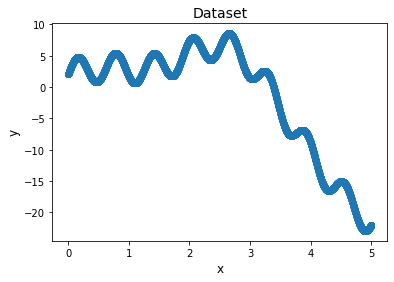

In [4]:
# since we have x and y in the same array we need to separate the two
X = in_data[:,0]
Y = in_data[:,1]
print(X.shape)
print(Y.shape)
plt.scatter(X,Y)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Dataset', fontsize=14)
plt.show()

In [5]:
# separate the training and testing data by slicing the arrays

test_X = X[:math.ceil(len(X)/10)]
train_X = X[math.ceil(len(X)/10):]
test_Y = Y[:math.ceil(len(Y)/10)]
train_Y = Y[math.ceil(len(Y)/10):]

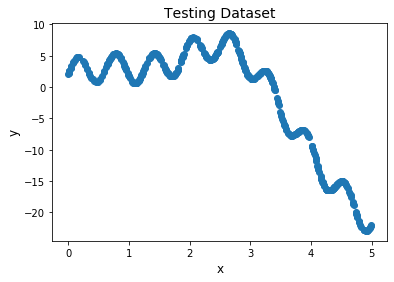

In [6]:
# plot for the testing data
plt.scatter(test_X,test_Y)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Testing Dataset", fontsize=14)
plt.show()

<span style='font-family:serif; font-size:18px'>
    Because the dataset has been randomly divided into testing the training sets, the scatter plot for the testing set looks similar to the rest of the dataset. This shows that the samples inducted into the testing dataset are a good representation of the entire dataset.
</span>

### Training
<span style='font-family:serif; font-size:18px'>
In this section, we train the models on the training dataset.
</span>

In [7]:
# Now we need to train each model on 10 different datasets

# partition the training data into 10 parts
partitions = 10
partitionedX = np.array_split(train_X,partitions)
partitionedY = np.array_split(train_Y,partitions)

# partitionedX and partitionedY are now lists of np.ndarrays, each of which
# represents 1 of the 10 partitions of the dataset

<span style='font-family:serif; font-size:18px'>
In the following cell, we train each model (i.e. polynomial of a particular degree) 10 times, once on each partition. The performance metrics of the model are computed by calculating its bias and variance on each data point (in the test set) across the 10 realizations of the model. The mean bias (or variance) of the model is then the mean of the bias (or variance) values calculated for each data point (in the test set).

The outer loop iterates over the 9 different models (i.e. polynomials of different degrees), while the inner loop iterates over the 10 different realizations of the model in consideration. Here, the model is trained on one of the partitions of the training set, and then tested on the test set. The code uses vectorization by invoking `numpy`'s functions instead of loops, which takes advantage of vector hardware/GPUs. The predictions of the model are then stored. After all 10 realizations have been trained and tested for a particular model, we find the average difference in predicted and actual values for each data point, averaged across the 10 realizations, which gives the bias of the model for each data point. Similarly, variance of the model is calculated for each data point by using the formula mentioned earlier. The bias (or variance) of the model is then the average of the bias (or variance) for each data point.
    
This process is repeated for each of the 10 different models.
</span>

+----------+----------+----------------+------------+
|   Degree |   Errors |   Squared Bias |   Variance |
|----------+----------+----------------+------------|
|        1 | 31.8182  |       31.7036  |  0.114661  |
|        2 |  6.42998 |        6.3815  |  0.0484772 |
|        3 |  5.58464 |        5.53191 |  0.0527221 |
|        4 |  3.41067 |        3.37414 |  0.0365305 |
|        5 |  3.11837 |        3.0819  |  0.0364664 |
|        6 |  2.66612 |        2.63666 |  0.0294649 |
|        7 |  2.53059 |        2.49313 |  0.037467  |
|        8 |  2.57902 |        2.52635 |  0.0526705 |
|        9 |  2.57551 |        2.52335 |  0.0521562 |
+----------+----------+----------------+------------+


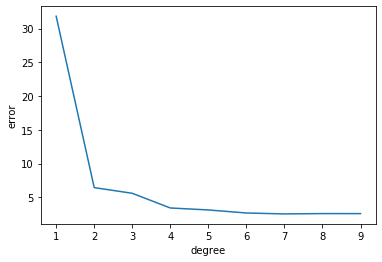

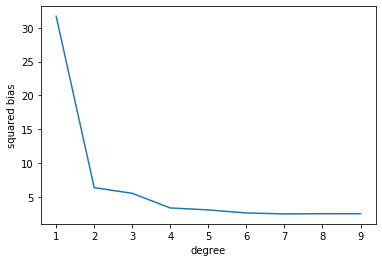

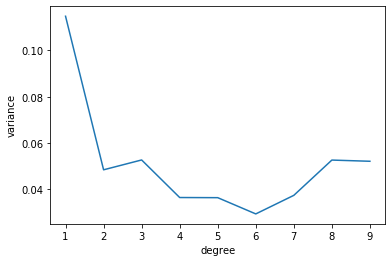

In [8]:
# for degree of polynomial 1 to 9 generate the models
errors = list()
bias_square = list()
variance = list()

test_fig, test_axs = plt.subplots(3, 3, figsize=(30, 30))

for currDeg in range(1,10):
    predict = list()
    diffs = list()
    error = list()
    poly = PolynomialFeatures(degree = currDeg)
    curr_test_X = poly.fit_transform(test_X.reshape(-1,1))
    # loop over all the 10 partitions to create 10 different models
    for chunk in range(partitions):
        
        curr_train_X = poly.fit_transform(partitionedX[chunk].reshape(-1,1))
        # get the regressor now
        regressor = linear_model.LinearRegression()
        regressor.fit(curr_train_X,partitionedY[chunk])
        
        # now test it
        prediction = regressor.predict(curr_test_X)
        
        # fill the lists
        diffs.append(prediction - test_Y)
        predict.append(prediction)
        error.append(mean_squared_error(test_Y,prediction))
        
        if chunk == 0:
            # make a plot for this model using the zeroeth chunk
            test_axs.flat[currDeg-1].scatter(test_X, test_Y, label='Actual Data')
            test_axs.flat[currDeg-1].scatter(test_X, prediction, label='Predicted Data')
            test_axs.flat[currDeg-1].set(xlabel='x', ylabel='y')
            test_axs.flat[currDeg-1].set_title('Degree ' + str(currDeg), fontweight='bold', size=20)
            test_axs.flat[currDeg-1].tick_params(labelsize=22)
            test_handles, test_labels = test_axs.flat[currDeg-1].get_legend_handles_labels()
            
        
    # calculate bias = E(f' - f) and variance = E[(f' - E[f'])^2] for each point accross models
    errors.append(np.mean(error))
    diffs = np.array(diffs)
    diffs = np.transpose(diffs)
    predict = np.array(predict)
    curr_bias = np.mean(np.mean(diffs,1)**2)

    bias_square.append(curr_bias)
    variance.append(np.mean((predict - np.mean(predict,0))**2))

# calculate the required list to print the graph for bias and variance
errors = np.array(errors)
bias_square = np.array(bias_square)
variance = np.array(variance)

table_dict = {
    'Degree': [i for i in range(1, 10)],
    'Errors': errors,
    'Squared Bias': bias_square,
    'Variance': variance
}

print(tabulate(table_dict, headers='keys', tablefmt='psql'))

plt.close()

plt.figure(10)
plt.plot(range(1,10),errors)
plt.xlabel('degree')
plt.ylabel('error')
plt.show(10)

plt.figure(11)
plt.plot(range(1,10),bias_square)
plt.xlabel('degree')
plt.ylabel('squared bias')
plt.show(11)

plt.figure(12)
plt.plot(range(1,10),variance)
plt.xlabel('degree')
plt.ylabel('variance')
plt.show(12)

# print(errors - (bias_square+variance))

### Analysis
<span style='font-family:serif; font-size:18px'>
Now that we have the plots for the squared bias and variance of each model, we can analyse and compare their performance.
    
#### Bias
As the degree of the polynomial hypothesis increases, the function becomes more flexible, allowing it to better mould itself to fit the training dataset. Hence, the error on the test dataset also decreases. Because the bias (the average difference between the predicted and actual values) effectively captures this error, we see a steadily deceasing trend in the bias values with an increase in degree of the hypothesis function.
    
The change, however, is not so marked after degree 4-5 which hints at the fact that the data is best modelled by a degree 4-5 hypothesis, and a further increase in degree of the hypothesis would be frivolous.
    
#### Variance
Save for an initial anomaly, the variance of the models shows a general increase with an increase in the degree of the hypothesis. This is because as the degree of the polynomial increases and it becomes more flexible, it also becomes more susceptible to minor variations in the training dataset. Hence, each time the model is trained, the increased flexibility of the higher degree polynomials causes the coefficients to turn out significantly different due to differences in the training set. Hence, the high variance on the test dataset.
    
The degree one hypothesis has an abnormally high variance because the lack of any flexibility at all causes the models to turn out vastly different from each other as the learning algorithm tries to fit them to points that vary slightly amongst the different training sets. Because the hypothesis lacks the flexibility to account for these variations, they cause the entire model to train drastically differently.
</span>

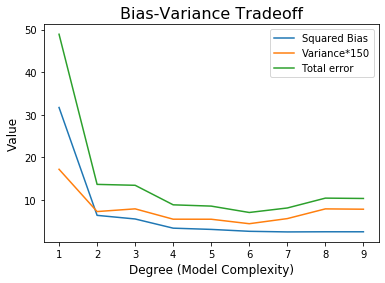

In [11]:
plt.figure(13)
plt.plot(range(1, 10), bias_square, label='Squared Bias')
plt.plot(range(1, 10), variance * 150, label='Variance*150')
plt.plot(range(1, 10), bias_square+ variance*150, label='Total error')
plt.xlabel('Degree (Model Complexity)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Bias-Variance Tradeoff', fontsize=16)
plt.legend()
plt.show(13)

<span style='font-family:serif; font-size:18px'>
This plot shows the squared bias and variance plotted on the same graph to visualize the Bias-Variance Tradeoff. Please note that variance has been scaled to 150 times the original to make the values of the same order.
</span>

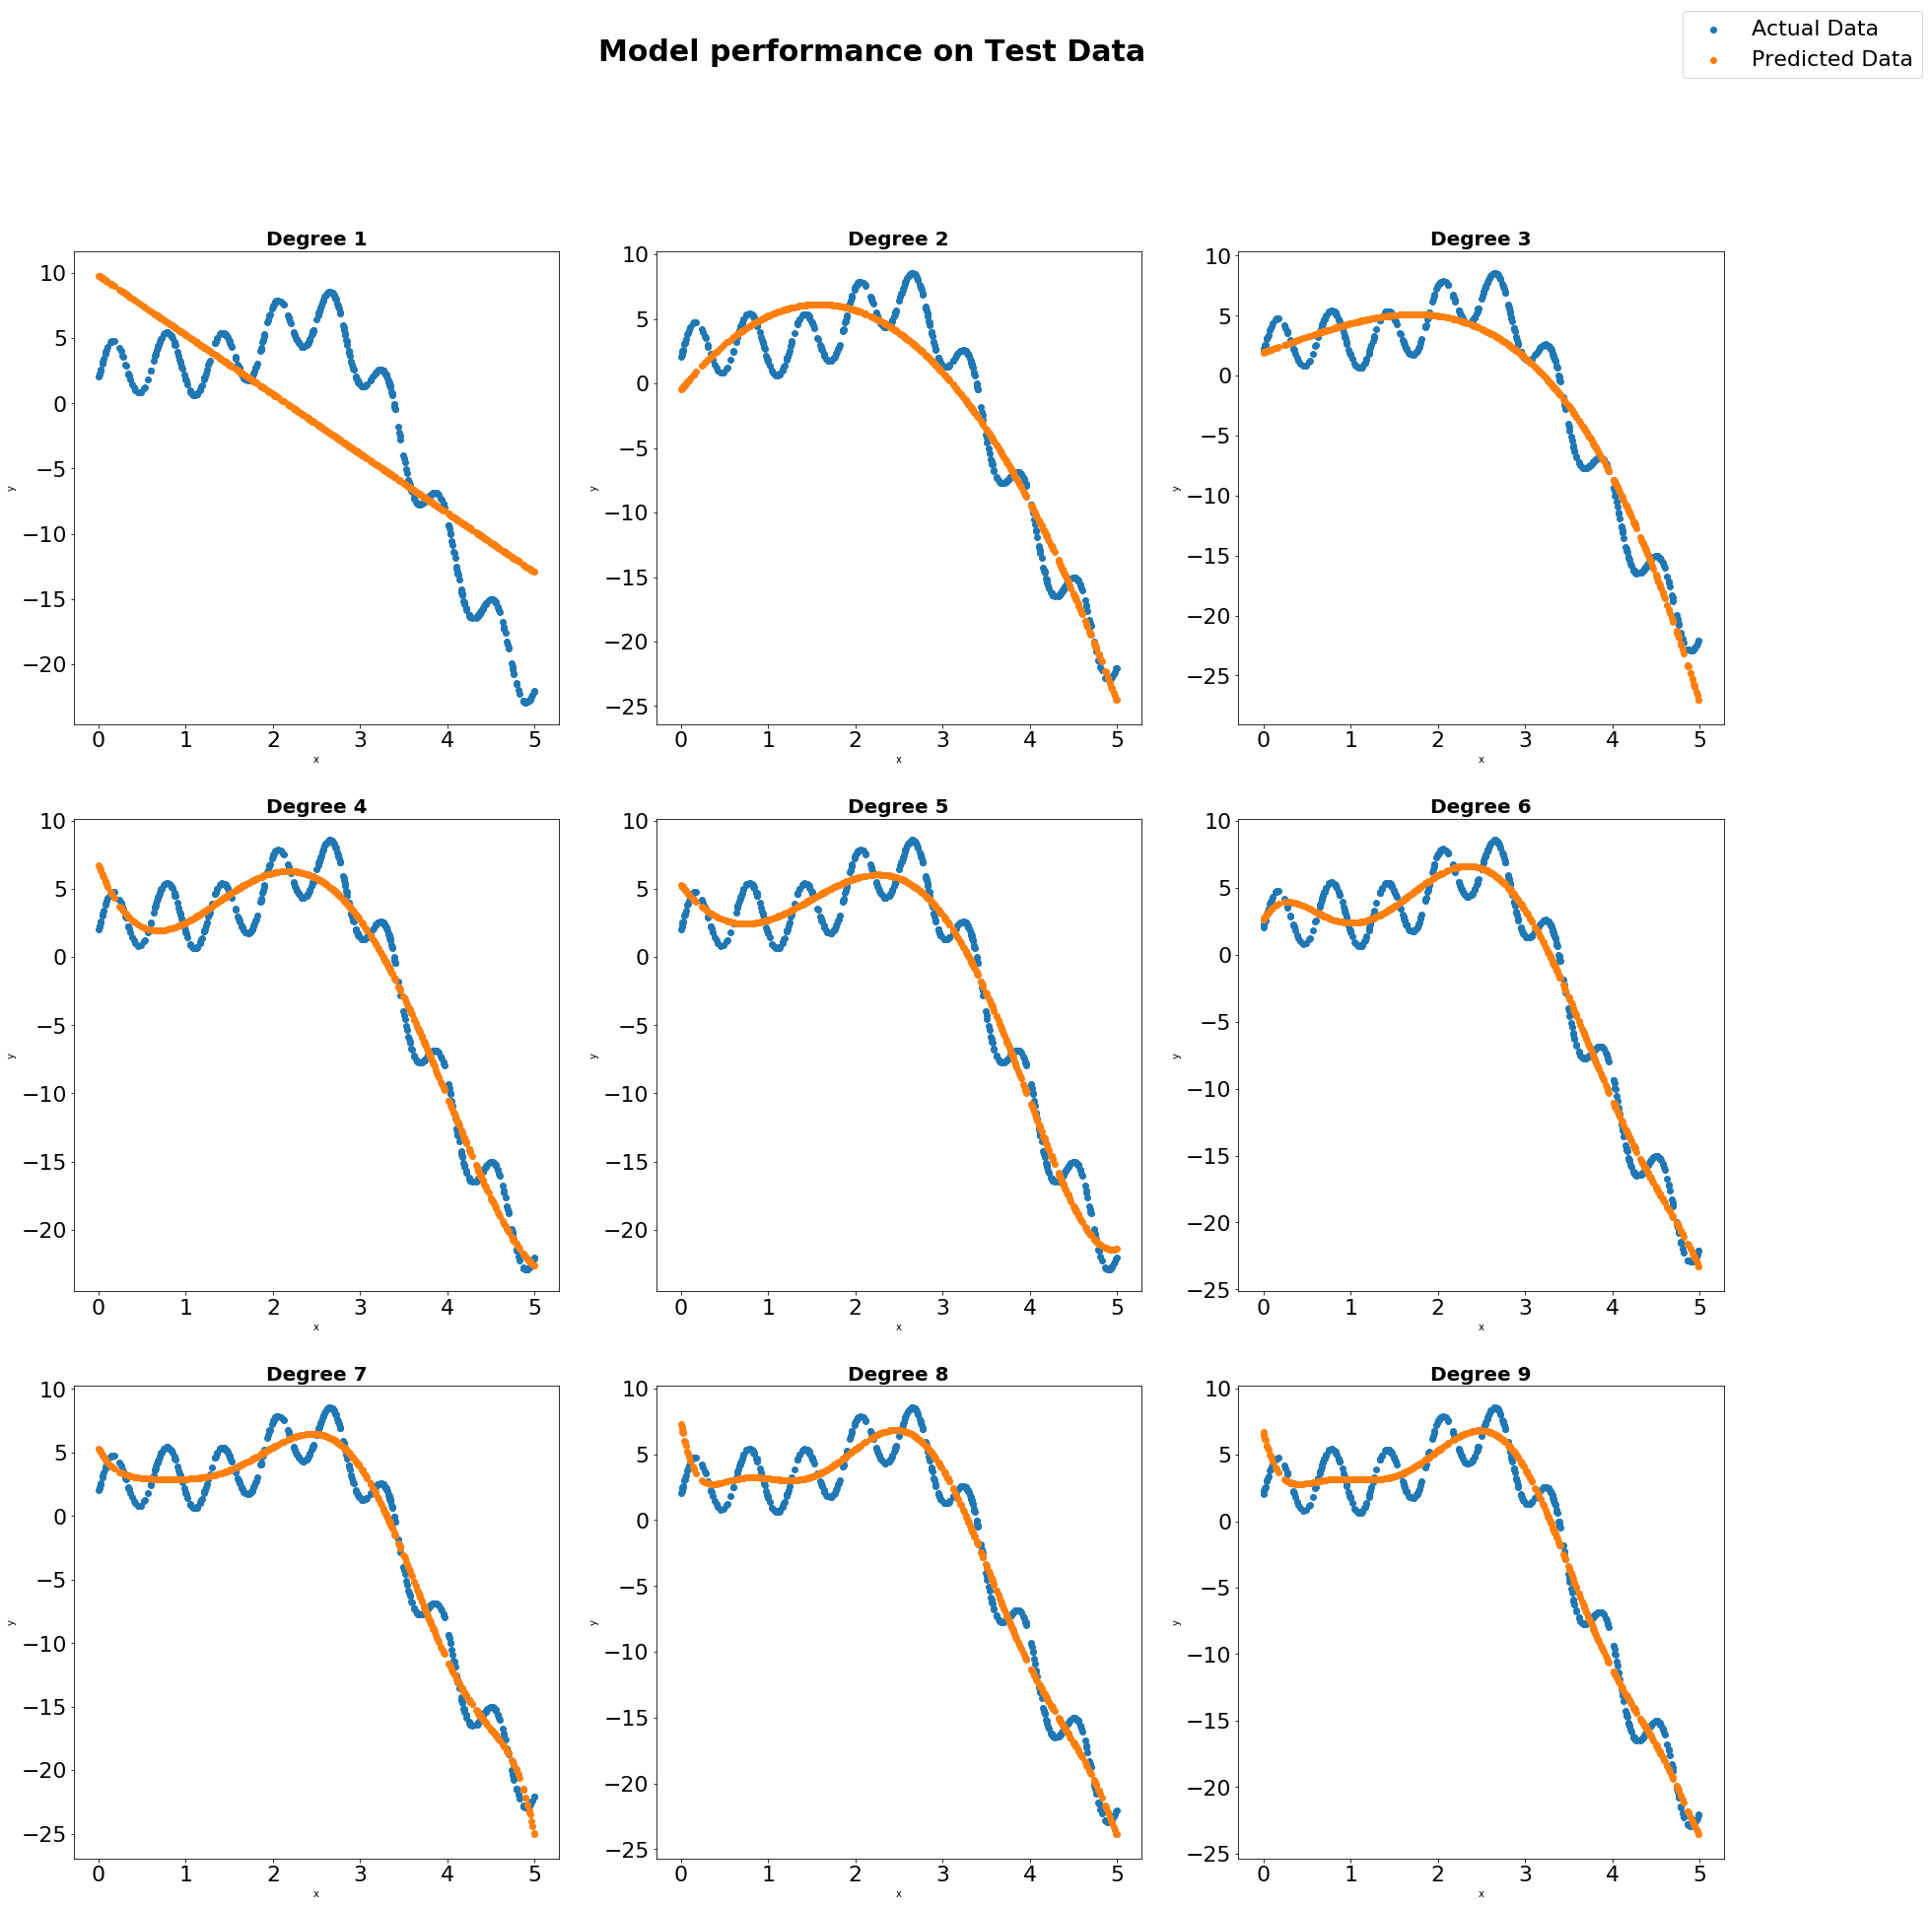

In [10]:
test_fig.legend(test_handles, test_labels, loc='upper right', fontsize=22)
test_fig.suptitle('Model performance on Test Data', fontweight='bold', size=30)
test_fig

<span style='font-family:serif; font-size:18px'>
These plots show the performance of each of the 9 models on the test dataset. Because we have 10 realizations of each model, we have just used the first one (since each is trained on a random partition of the dataset).

These plots clearly show the trends that have been described above. As the degree of the hypothesis increases, the output more closely follows the actual values - indicating a lower error, or bias on the test (as well as training) dataset. However, there is not much of a difference once the degree crosses 7 - which indicates that the optimal degree of the hypothesis would be around 4-6.

One can also notice how minor variations in the dataset affect the higher degree polynomials. Although the plots do not explicitly show it, this can easily be extrapolated to indicate a high variance in those models.
</span>

### Conclusion

<span style='font-family:serif; font-size:18px'>
    
From the graphs, it is evident that an increase in degree beyond 6 does not bring much benefit in terms of bias, but just increases the variance for the worse. Because degree 4 has the least variance amongst degrees 4 to 6, it might be the best suited model for this case.
    
</span>